In [14]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
%matplotlib inline

Choosing a cluster assignment is like flipping a coin
but that coin isn't necessarily fair... 
When we estimate the weights, we have observed some 
sequence of coin flips and we're trying
to figure out the probability of heads.

In [7]:
K = 2                    # Number of outcomes
N = 100                  # Number of flips
p = 0.75                 # Probability of heads
pi = np.array([p, 1-p])  # Vector of [Pr(heads), Pr(tails)]

# Sample a sequence of flips
Z = npr.choice(K, size=(N,), p=pi)

# Count the number of heads and tails
N_heads = (Z==0).sum()
N_tails = (Z==1).sum()

print(Z)

[0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0
 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Maximum Likelihood Estimate
The simplest approach is the "maximum likelihood estimate"
I.e. what is the value of p that is most likely to have generated this sequence?
As we intuitively expect, this is simply the fraction of heads.

In [43]:
p_mle = N_heads / float(N)
print("MLE: {}".format(p_mle))

MLE: 0.77


# Maximum a Posteriori Estimate
Bayesians work instead with the posterior distribution over the weight of the coin.
We combine our prior beliefs about the weight of the coin with the data that we have
observed. How should we think of the prior? Intuitively, it corresponds to a set of 
"pseudocounts." How many times have you seen this coin (or a similar one) 
come up heads or tails in the past? 

Equivalently, we can think of having a generative model that creates coins. Think
of it as a mint. The mint has some parameters that govern the "weight", or bias, of
the coin. Again, those parameters correspond to pseudocounts; how many times have 
coins from this mint come up heads or tails.  These specify the distribution over
weights of coins from this mint.

In [44]:
# How many flips have you "seen" before?
h = 2.
t = 2.

# maximum a posteriori estimate of p
# combine the heads we've seen this time with 
# the "pseudocounts" we've seen before, i.e. the
# parameters of the mint.
p_map = (N_heads + h) / (N + h + t)
print("MAP: {}".format(p_map))

MAP: 0.7596153846153846


# Likelihood of Z given p
$ \Pr(Z | p) = \prod_n \begin{cases} p & \text{if } Z==0 \\ 1-p & \text{if } Z==1 \end{cases}$

$ \Pr(Z | p) = p^{N_{heads}} (1-p)^{N_{tails}} $

# Prior on p
We want it to have the same form
$\Pr(p | h, t) \propto p^{h-1} (1-p)^{t-1}$

This is called a beta distribution, and we write it as, $Beta(p | h,t)$  

# Joint probability 
$\Pr(Z, p) = \Pr(Z | p) \Pr(p | h, t)$ 

$\Pr(Z, p) \propto p^{N_{heads}} (1-p)^{N_{tails}} \times p^{h-1} (1-p)^{t-1}$ 

$\Pr(Z, p) \propto p^{N_{heads} + h -1} (1-p)^{N_{tails} + t-1}$ 

# Posterior distribution of p given Z

$ \Pr(p | Z) = \frac{\Pr(Z, p)}{ \Pr(Z)}  \propto \Pr(Z, p)$

$ \Pr(p | Z) \propto p^{N_{heads} + h -1} (1-p)^{N_{tails} + t-1}$

$\Pr(p | Z) \propto Beta(p | N_{heads} + h, N_{tails} + t)$

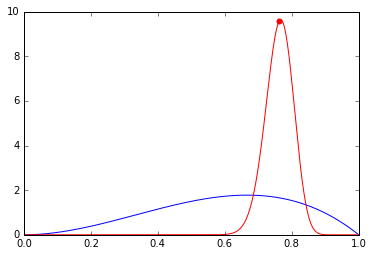

In [45]:
# Plotting beta distributions
from scipy.stats import beta
h = 3.0
t = 2.0
prior = beta(h, t)
posterior = beta(N_heads + h, N_tails + t)

ps = np.linspace(0,1,1000)
plt.plot(ps, prior.pdf(ps), '-b')
plt.plot(ps, posterior.pdf(ps), '-r')

# Compute the MAP
p_map = (N_heads + h) / (N + h + t)
plt.plot(p_map, posterior.pdf(p_map), 'ro', markeredgecolor="none")

# Loaded Dice
Now suppose we don't just have two outcomes (heads or tails), but rather $K$ outcomes.
That is, suppose that we are working with loaded dice instead of biased coins. 
The same idea will still hold! Let's derive the prior and posterior distribution 
that works with this multiclass likelihood.

# Likelihood of Z given p
$ \Pr(Z | \pi) = \prod_n \begin{cases} \pi_1 & \text{if } Z==1 \\ \pi_2 & \text{if } Z==2 \\ ... \\ \pi_K & \text{if } Z==K \end{cases}$

$ \Pr(Z | \pi) = \prod_k \pi_k^{\sum_n I(Z=k)}$

$ \Pr(Z | \pi) = \prod_k \pi_k^{N_k}$

# Prior on p
We want it to have the same form
$\Pr(\pi | \alpha_1, ..., \alpha_K) \propto \prod_k \pi_k^{\alpha_k-1}$.

This is called a *Dirichlet* distribution, which we write as $Dir(p | \alpha)$. 
Here, $\alpha$ plays the role of pseudocounts -- that is, $\alpha_k$ is the number
of times we've seen the die come up on side $k$. The Dirichlet distribution is 
like a dice factory. Each sample is a loaded die.

# Joint probability 
$\Pr(Z, \pi) = \Pr(Z | \pi) \Pr(\pi | \alpha)$ 

$\Pr(Z, \pi) \propto \prod_k \pi_k^{N_k} \times \prod_k \pi_k^{\alpha_k-1}$ 

$\Pr(Z, p) \propto \prod_k \pi_k^{N_k + \alpha_k -1}$ 

# Posterior distribution of p given Z

$\Pr(\pi | Z) \propto Dir(p | N_1 + \alpha_1, ..., N_K + \alpha_K)$

In [54]:
# Plot samples from the Dirichlet distribution.
def plot_dirichlet(pis):
    N, K = pis.shape
    plt.figure(figsize=(N*3, 4))
    for n in range(N):
        plt.subplot(1,N,n+1)
        plt.bar(np.arange(K), pis[n], color='k', alpha=0.5)
        plt.ylim(0,1)
        plt.xlabel("$\pi$")
        plt.title("Sample {}".format(n+1))
        


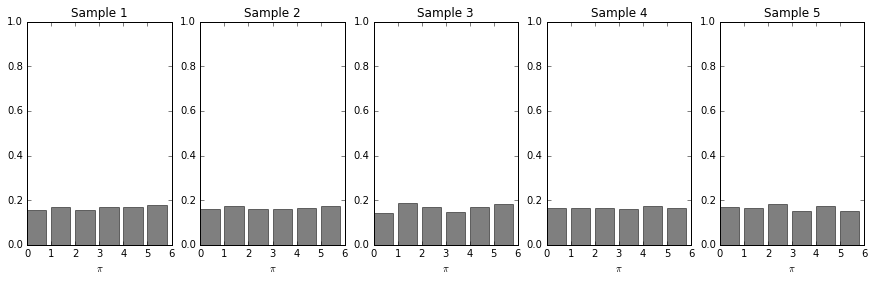

In [61]:
# When we have lots of pseudocounts, the dice
# are very certain.
K = 6
N = 5
alpha = 100. * np.ones(K)
pis = npr.dirichlet(alpha, size=(N,))
plot_dirichlet(pis)

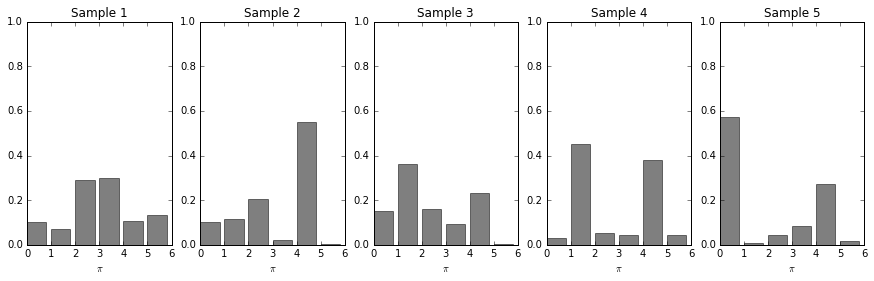

In [62]:
# When we have one pseudocount per outcome, the distribution
# over dice is uniform over all possible weights
K = 6
N = 5
alpha = 1. * np.ones(K)
pis = npr.dirichlet(alpha, size=(N,))
plot_dirichlet(pis)

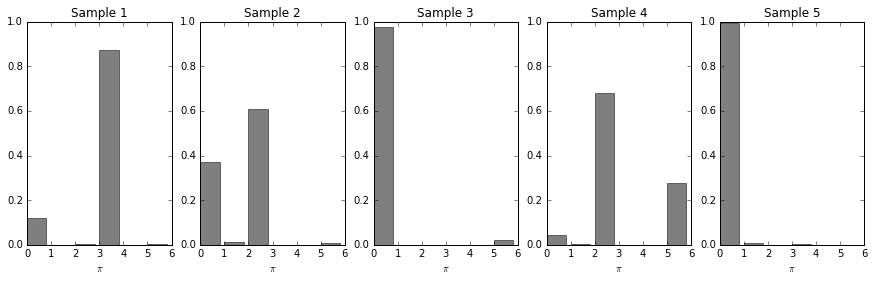

In [63]:
# When we have fewer than one pseudocount per face, the dice
# are very "peaky" and biased.
K = 6
N = 5
alpha = 0.1 * np.ones(K)
pis = npr.dirichlet(alpha, size=(N,))
plot_dirichlet(pis)